# LINMA2171 - Numerical Analysis: Approximation, Interpolation, Integration
## Homework 4

---

### Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from numpy.polynomial import Polynomial

### Continous minimax approximation

In [17]:
# Phi_0 = 1, Phi_1 = x, ..., Phi_n = x**n
def basis(x, i):
    return np.pow(x, i)

def solve_system(f, xi):
    """Returns coeff a and h from Remez algorithm (step 3)
    """
    n = xi.shape[0] - 2
    A = np.zeros((n+2, n+2))
    b = f(xi)

    # n+1 first columns
    for i in range(n+1):
        col_i = basis(xi, i)
        A[:, i] = col_i

    # last column
    last_col = np.pow(-np.ones(n+2), np.arange(n+2))
    A[:, n+1] = last_col

    coeffs = np.linalg.solve(A, b)
    return coeffs[:-1], coeffs[-1]

def eta(f, p: Polynomial, interval=(-1, 1)):
    "Finds and returns the point at which the error is maximized"
    eval_points = np.linspace(interval[0], interval[1], 100000)
    errors = f(eval_points) - p(eval_points)
    return eval_points[np.argmax(np.abs(errors))]

def replace_xi(f, p: Polynomial, xi, eta):
    "Returns the index of xi that is getting replaced by eta"
    n = xi.shape[0] - 2
    errors = f(xi) - p(xi)
    err_eta = f(eta) - p(eta)
    idx = -1

    if eta < xi[0]:
        if np.sign(err_eta) == np.sign(errors[0]):
            idx = 0
        else:
            idx = n + 1

    elif eta > xi[-1]:
        if np.sign(err_eta) == np.sign(errors[-1]):
            idx = n + 1
        else:
            idx = 0

    else:
        for i in range(n + 1):
            if xi[i] < eta < xi[i + 1]:
                if np.sign(err_eta) == np.sign(errors[i]):
                    idx = i
                else:
                    idx = i + 1
                break

    return idx

def remez_algorithm(f, xi_base, interval=(-1, 1), tol=1e-6, max_iter=1000):
    xi = xi_base.copy()

    errors_est = []

    for iteration in range(max_iter):
        coeffs, h = solve_system(f, xi)
        p = Polynomial(coeffs, domain=interval)

        eta_point = eta(f, p, interval)
        max_error = np.abs(f(eta_point) - p(eta_point))
        errors_est.append(max_error)
        idx_replace = replace_xi(f, p, xi, eta_point)

        xi_new = xi.copy()
        xi_new[idx_replace] = eta_point
        xi_new = np.sort(xi_new)

        # Check convergence
        if max_error - np.abs(h) < tol:
            break

        xi = xi_new

    return p, errors_est


### Initialization strategies

In [18]:
def eq_points(n):
    "Equally spaced points in [-1, 1]"
    return np.linspace(-1, 1, n + 2)

def cheb_points(n):
    "Chebyshev points in [-1, 1]"
    k = np.arange(n + 2)
    return -np.cos(np.pi * k / (n + 1))

### 1. Approximations vs. $f(x)$

Equidistant n=2, coeffs: [ 1.08028071 -0.61002015 -0.36815625]
Equidistant n=4, coeffs: [ 0.95666522 -0.43899686  0.27598242 -0.21747441 -0.52052317]
Equidistant n=8, coeffs: [ 0.97895241 -0.46886261  0.57996477 -0.38987643 -3.72800988  0.81258329
  6.18235761 -0.63453043 -3.30114044]


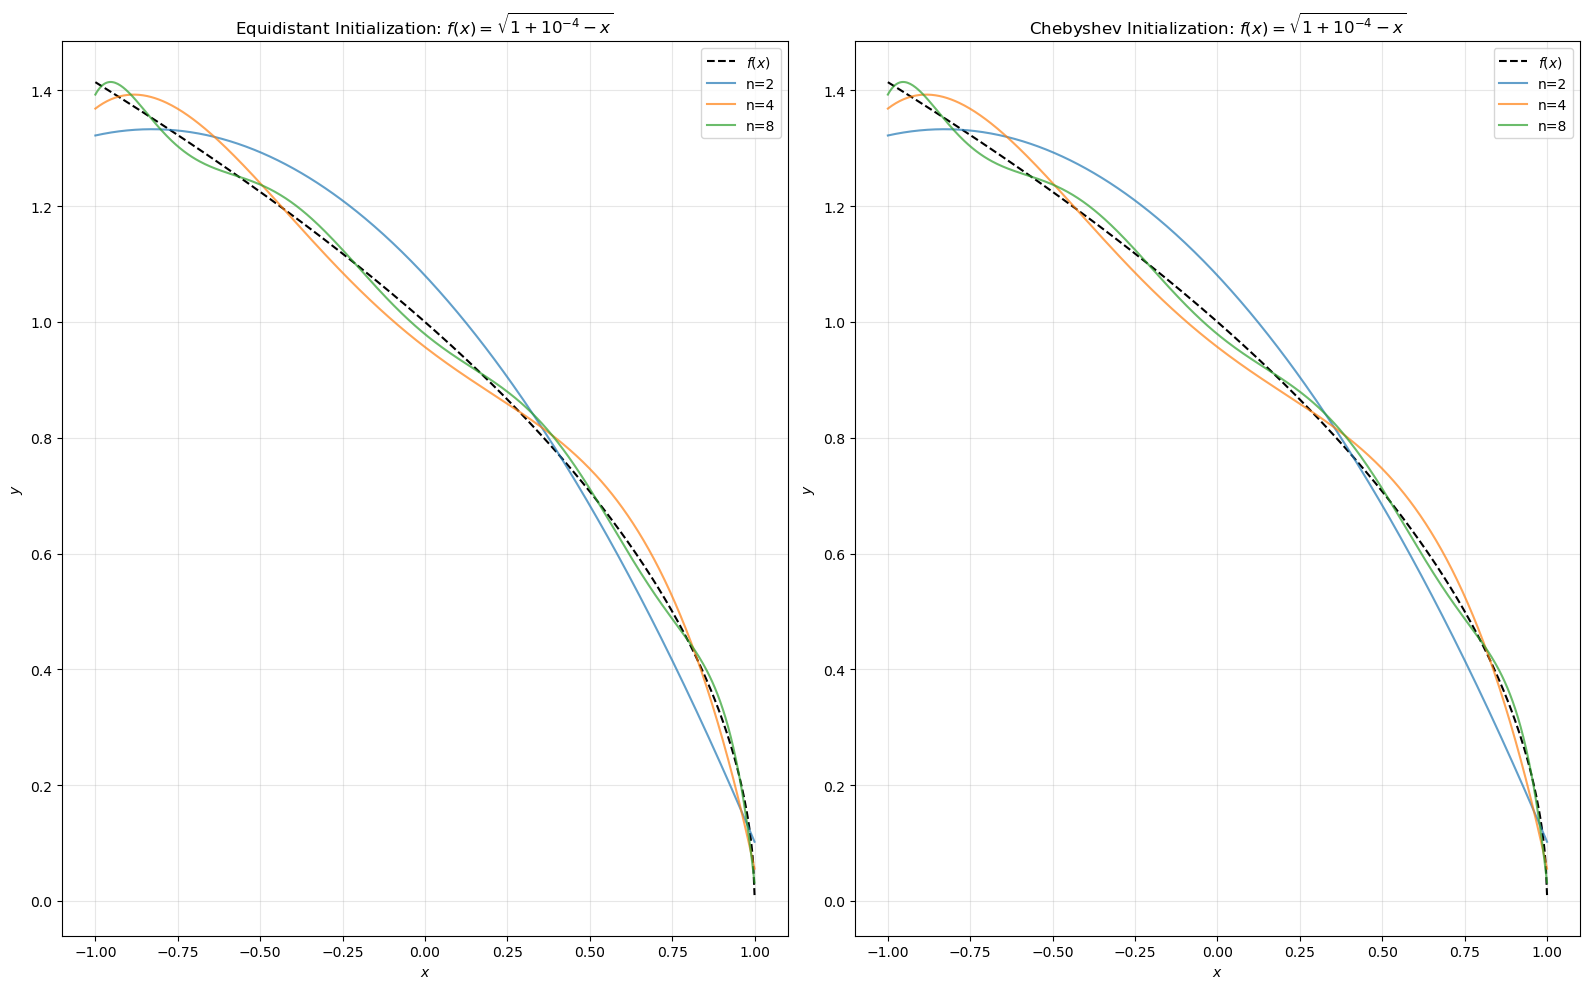

Equidistant n=2, coeffs: [ 5.00000353e-01  7.39374322e-01 -3.52501373e-07]
Equidistant n=4, coeffs: [ 4.99999917e-01  1.36202130e+00  1.53394611e-06 -9.80930059e-01
 -1.45088469e-06]
Equidistant n=8, coeffs: [ 4.99999993e-01  2.04371055e+00  1.13028048e-07 -5.96295983e+00
 -5.65196829e-07  8.39323482e+00  1.02825174e-06 -4.00742942e+00
 -5.68652614e-07]


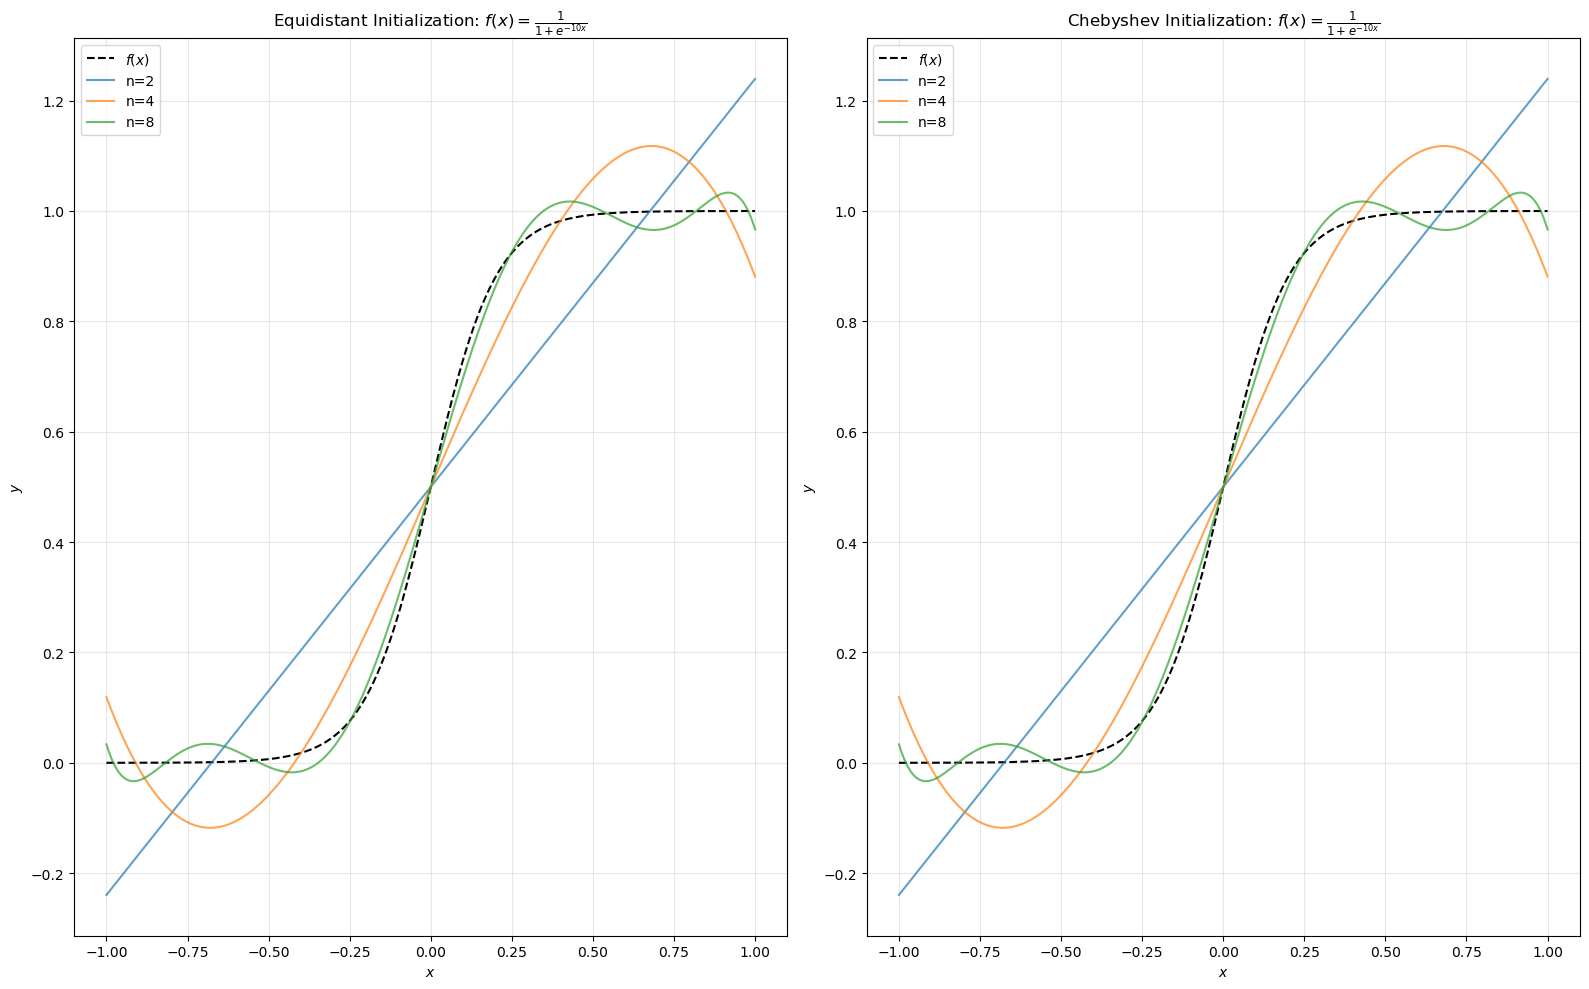

In [22]:
def plot_approximations(f, interval=(-1, 1), f_label="", filename="f"):
    """For fixed degrees n in {2, 4, 8}, plot the resulting minimax polynomial approximation pn for f and each initialization strategy, together with the original function.
    """
    num_points = 500
    x = np.linspace(interval[0], interval[1], num_points)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
    
    # Equidistant strategy
    ax1.plot(x, f(x), label=r'$f(x)$', color='black', linestyle='--')
    for n in [2, 4, 8]:
        xi_eq = eq_points(n)
        p_eq, _ = remez_algorithm(f, xi_eq, interval)

        print(f"Equidistant n={n}, coeffs: {p_eq.coef}")

        ax1.plot(x, p_eq(x), label=f'n={n}', alpha=0.7)
    ax1.set_title(rf'Equidistant Initialization: $f(x) = {f_label}$')
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Chebyshev strategy
    ax2.plot(x, f(x), label=r'$f(x)$', color='black', linestyle='--')
    for n in [2, 4, 8]:
        xi_cheb = cheb_points(n)
        p_cheb, _ = remez_algorithm(f, xi_cheb, interval)
        ax2.plot(x, p_cheb(x), label=f'n={n}', alpha=0.7)
    ax2.set_title(rf'Chebyshev Initialization: $f(x) = {f_label}$')
    ax2.set_xlabel(r'$x$')
    ax2.set_ylabel(r'$y$')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/approx_' + filename + '.svg', format='svg')
    plt.show()

f = lambda x: np.sqrt(1 + 1e-4 - x)
plot_approximations(f, f_label=r'\sqrt{1 + 10^{-4} - x}', filename="f1")

f = lambda x: 1 / (1 + np.exp(-10 * x))
plot_approximations(f, f_label=r'\frac{1}{1 + e^{-10x}}', filename="f2")


### 2. Minimax error vs. $n$

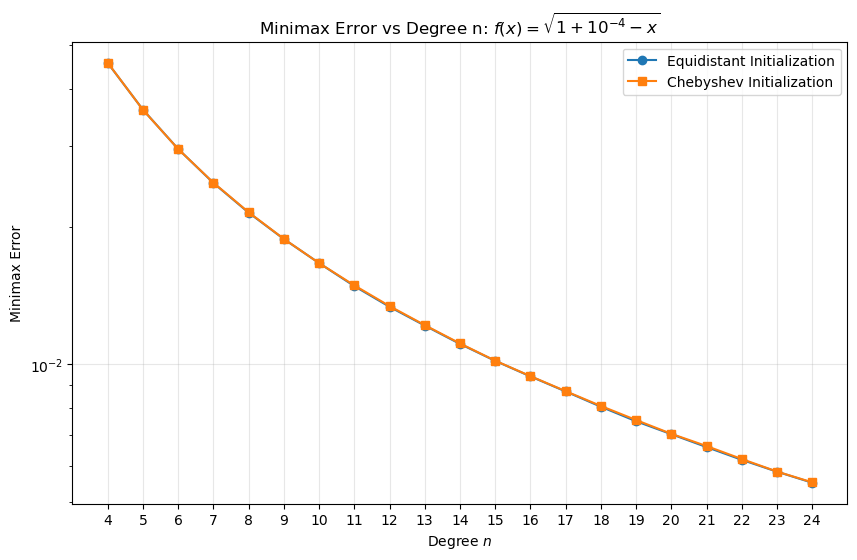

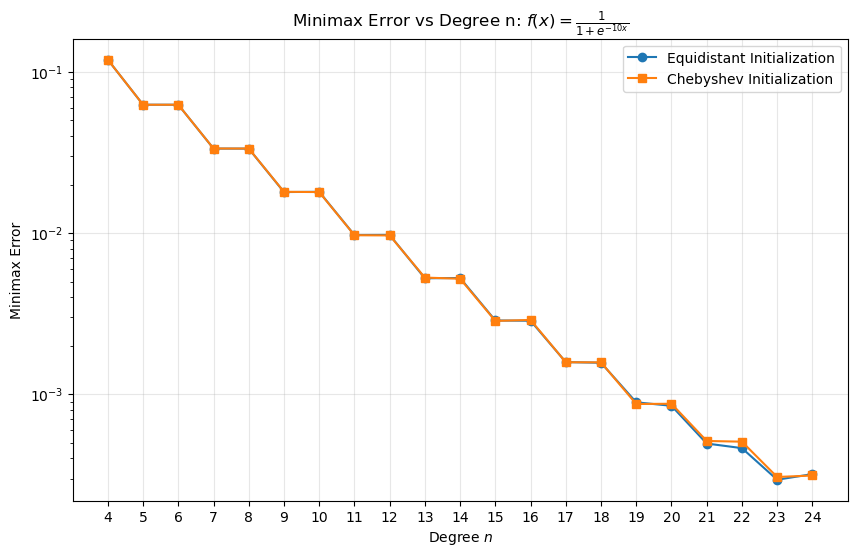

In [20]:
def plot_errors(f, interval=(-1, 1), f_label="", filename="f"):
    """For n from 4 to 24, plot the minimax error as a function of n for each initialization strategy.
    """
    ns = np.arange(4, 25)
    errors_eq = []
    errors_cheb = []

    for n in ns:
        xi_eq = eq_points(n)
        _, err_eq = remez_algorithm(f, xi_eq, interval, tol=1e-4)
        errors_eq.append(err_eq[-1])

        xi_cheb = cheb_points(n)
        _, err_cheb = remez_algorithm(f, xi_cheb, interval, tol=1e-4)
        errors_cheb.append(err_cheb[-1])

    plt.figure(figsize=(10, 6))
    plt.semilogy(ns, errors_eq, marker='o', label='Equidistant Initialization')
    plt.semilogy(ns, errors_cheb, marker='s', label='Chebyshev Initialization')
    plt.title(rf'Minimax Error vs Degree n: $f(x) = {f_label}$')
    plt.xticks(ns)
    plt.xlabel(r'Degree $n$')
    plt.ylabel(r'Minimax Error')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig('figures/error_' + filename + '.svg', format='svg')
    plt.show()


f = lambda x: np.sqrt(1 + 1e-4 - x)
plot_errors(f, f_label=r'\sqrt{1 + 10^{-4} - x}', filename="f1")

f = lambda x: 1 / (1 + np.exp(-10 * x))
plot_errors(f, f_label=r'\frac{1}{1 + e^{-10x}}', filename="f2")


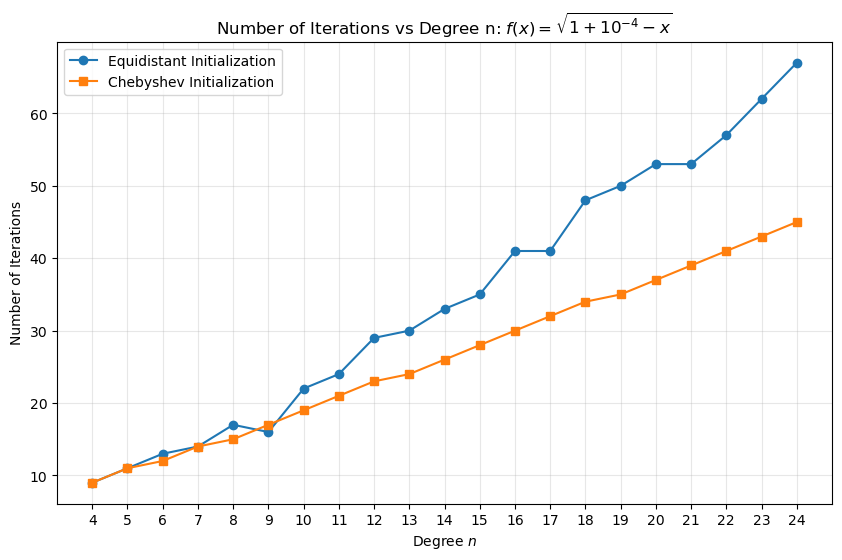

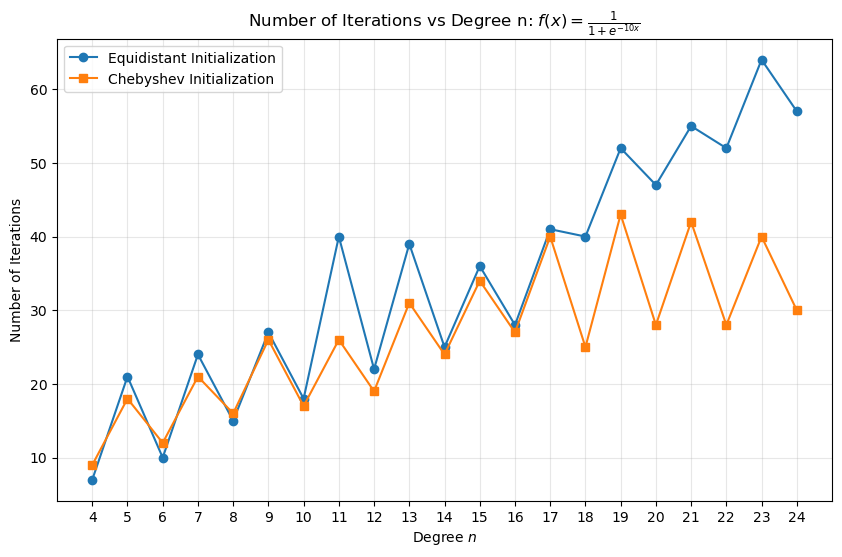

In [21]:
def plot_num_iter(f, interval=(-1, 1), f_label="", filename="f"):
    """For n from 4 to 24, plot the number of iterations until convergence for each initialization strategy.
    """
    ns = np.arange(4, 25)
    iters_eq = []
    iters_cheb = []

    for n in ns:
        xi_eq = eq_points(n)
        _, err_eq = remez_algorithm(f, xi_eq, interval, max_iter=int(1e9))
        iters_eq.append(len(err_eq))

        xi_cheb = cheb_points(n)
        _, err_cheb = remez_algorithm(f, xi_cheb, interval, max_iter=int(1e9))
        iters_cheb.append(len(err_cheb))

    plt.figure(figsize=(10, 6))
    plt.plot(ns, iters_eq, marker='o', label='Equidistant Initialization')
    plt.plot(ns, iters_cheb, marker='s', label='Chebyshev Initialization')
    plt.title(rf'Number of Iterations vs Degree n: $f(x) = {f_label}$')
    plt.xticks(ns)
    plt.xlabel(r'Degree $n$')
    plt.ylabel(r'Number of Iterations')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig('figures/iterations_' + filename + '.svg', format='svg')
    plt.show()


f = lambda x: np.sqrt(1 + 1e-4 - x)
plot_num_iter(f, f_label=r'\sqrt{1 + 10^{-4} - x}', filename="f1")

f = lambda x: 1 / (1 + np.exp(-10 * x))
plot_num_iter(f, f_label=r'\frac{1}{1 + e^{-10x}}', filename="f2")